In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

In [2]:
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
#data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

In [3]:
# functions for downsample

def cartesian_mask(factor, PE_direction, distribution):
    acceleration, center_fraction = factor
    size = 320
    mask = np.zeros((size, size), dtype=bool)
    num_cols = size
    num_low_frequencies = round(num_cols * center_fraction)
       
    if (distribution == "uniform"):
        adjusted_accel = round((acceleration * (num_low_frequencies - num_cols)) / (num_low_frequencies * acceleration - num_cols))
        offset = np.random.randint(0, round(adjusted_accel))
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = np.around(accel_samples).astype(np.uint)
    elif (distribution == "random"):
        prob = (num_cols / acceleration - num_low_frequencies) / (num_cols - num_low_frequencies)
        accel_samples = np.random.uniform(size=num_cols) < prob
    
    if (PE_direction == "LR"):
        mask[:, round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2)] = True
        mask[:, accel_samples] = True
    elif (PE_direction == "AP"):
        mask[round((num_cols - num_low_frequencies - 2) / 2):round((num_cols + num_low_frequencies - 2) / 2), :] = True
        mask[accel_samples,:] = True
 
    return mask

In [4]:
# functions for motion

def c2h(X):
    # Convert cartesian to homogeneous coordinates.
    # Input:
    # X - cartesian coordinates
    # Output:
    # Xh - homogeneous coordinates

    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # Convert a 2D transformation matrix to homogeneous form.
    # Input:
    # T - 2D transformation matrix
    # t - 2D translation vector
    # Output:
    # Th - homogeneous transformation matrix

    T1 = np.concatenate((T,t[:,None]),axis=1)
    n = np.zeros([1,T1.shape[1]])
    n[-1,-1] = 1
    Th = np.append(T1, n, axis=0)
    
    return Th

def rotate(phi):
    # 2D rotation matrix.
    # Input:
    # phi - rotation angle
    # Output:
    # T - transformation matrix

    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(I, Th):
    # Image transformation by inverse mapping.
    # Input:
    # I - image to be transformed
    # Th - homogeneous transformation matrix
    # output_shape - size of the output image (default is same size as input)
    # Output:
    # It - transformed image
    # Xt - remapped coordinates

    # output size is same as input
    output_shape = I.shape

    # spatial coordinates of the transformed image
    x = np.arange(0, output_shape[1])
    y = np.arange(0, output_shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    # perform inverse coordinates mapping
    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    It = ndimage.map_coordinates(I, [Xt[1,:], Xt[0,:]], order=1, mode='constant').reshape(output_shape)

    return It, Xt

def image_transform_test(I, ang_deg, trans_x, trans_y):

    # rotation around the image center
    centre = int(I.shape[0]/2)
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(np.eye(2), centre*np.ones(2))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(np.eye(2), -centre*np.ones(2))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(np.eye(2), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    It, Xt = image_transform(I, T_tot)
    
    return It, Xt

def rigid_motion(image, n_movements, ang_std, trans_std, pe_direction):
    # normalize image between 0 and 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # generate movement parameters
    grid_size = image.shape
    locs = np.sort(np.random.permutation(grid_size[0])[:n_movements])
    ang = np.random.normal(0, ang_std, (n_movements+1))
    trans_x = np.random.normal(0, trans_std, (n_movements+1))
    trans_y = np.random.normal(0, trans_std, (n_movements+1))
    
    # initiate k-space and parameters
    k_space = transform_image_to_kspace(image)    
    ang_tot = ang[0]
    trans_x_tot = trans_x[0]
    trans_y_tot = trans_y[0]
    
    # add first movement to k-space
    It_0, Xt_0 = image_transform_test(image, ang_tot, trans_x_tot, trans_y_tot)
    kspace_It_0 = transform_image_to_kspace(It_0)
    if (pe_direction == "horizontal"):
        k_space[:locs[0], :] = kspace_It_0[:locs[0], :]
    elif (pe_direction == "vertical"):
        k_space[:, :locs[0]] = kspace_It_0[:, :locs[0]]
    
    # add middle movements to k-space
    for i in range(n_movements):
        ang_tot += ang[i+1]
        trans_x_tot += trans_x[i+1]
        trans_y_tot += trans_y[i+1]
        It_i, Xt_i = image_transform_test(image, ang_tot, trans_x_tot, trans_y_tot)
        kspace_It_i = transform_image_to_kspace(It_i)
        if i < n_movements:
            if (pe_direction == "horizontal"):
                k_space[locs[i-1]:locs[i], :] = kspace_It_i[locs[i-1]:locs[i], :]
            elif (pe_direction == "vertical"):
                k_space[:, locs[i-1]:locs[i]] = kspace_It_i[:, locs[i-1]:locs[i]] 
        elif i == n_movements:
            if (pe_direction == "horizontal"):
                k_space[locs[i-1]:, :] = kspace_It_i[locs[i-1]:, :]
            elif (pe_direction == "vertical"):
                k_space[:, locs[i-1]:] = kspace_It_i[:, locs[i-1]:] 
    
    return k_space

def periodic_motion(kspace):
    x = np.linspace(-np.pi, np.pi, kspace.shape[1])
    y = np.linspace(-np.pi, np.pi, kspace.shape[0])
    kx, ky = np.meshgrid(x, y)

    # parameters
    alpha = np.random.uniform(0.1, 5) # respiratory frequency
    delta = np.random.uniform(0, 20) # shift along PE direction
    beta = np.random.uniform(0, np.pi/4) # phase
    ky0 = np.random.uniform(np.pi/10, np.pi/8) # center K-space lines without phase shift errors
    
    # phase error outside of center
    phase_error = ky*delta*np.sin(alpha*ky + beta)
    
    # no motion in the center of k-space
    phase_error[abs(ky) < ky0] = 0

    # add phase error to k-space
    kspace = kspace*np.exp(-1j*phase_error)

    return kspace

In [5]:
# # functions for bias
# import numpy as np
# from scipy import interpolate
# import scipy.ndimage as ndimage
# import matplotlib.pyplot as plt
# import scipy.io
# import scipy.misc

# def BiasGenerator(size,
#                   batch_size=None,
#                   bias_range=None,
#                   freq=None):
#     """A generator of bias fields of specified size and parameters.
#     The images are organised in a directory for each image, a subdirectory
#     for each channel, and the third-dimension slices for each channel are
#     in those subdirectories.
#     It will be assumed that the subdirectories (channels) of the given
#     directory (image) contains different "channels" (different image modes,
#     for instance), and they will be returned as such. The subdirectories and
#     their order is determined by the list ``channel_names``.
#     Parameters
#     ----------
#     batch_size : int or None, optional
#         The number of images to return at each yield. If None, all images will
#         be returned. If there are not enough images to return in one batch, the
#         source directory is considered exhausted, and StopIteration will be
#         thrown. Default is 1, which means to return only one image at the time.
#     size : array of int, length 2, optional
#         The (possibly cropped image) will be resized to this absolute size.
#         Default is None, do not resize the images. See also
#         ``keep_aspect_ratio`` and ``minimum_size``.
    
#     lbias_range: int, optional
#         The range of the bias field. N4 experiments use the following:
#         0.2 (20%) for [0.9 1.1] and 0.4 (40%) [0.8 1.2].
        
#     freq: float
#         In the range of [0 1] it sets 
#     Examples
#     --------
#     >>> import numpy as np
#     >>> from nethin.data import DicomGenerator
#     """
    
#     random_bias = 0
    
#     if len(size)==2:
#         size[0] = int(size[0])
#         size[1] = int(size[1])
#     elif len(size)==1:
#         size = [int(size[0]), int(size[0])]
#     else:
#         raise RuntimeError("Check the input size of the bias field.")
        
#     if batch_size is None:
#         batch_size = 1
#     else:
#         batch_size = max(1, int(batch_size))
    
#     if freq is None:
#         freq = 0
        
#     if bias_range is None:
#         # Do Random between [0.1 0.4]
#         # Works great for training set.
#         random_bias = 1
#         #bias_range = 0.2
    
#     grid_x, grid_y = np.mgrid[0:size[0]:1, 0:size[1]:1]
#     num_points = np.random.randint(198*freq+2,298*freq+8)
#     BiasFields = np.zeros((size[0], size[1],batch_size))
#     for image_i in range(batch_size):
#         if random_bias:
#             bias_range = np.random.uniform(0.2, 0.4)
#         z = np.random.uniform(size=num_points)
#         points = np.transpose(np.random.uniform(size=(2,num_points)))
#         points[:,0] = points[:,0]*size[0]*1.2 - size[0]*0.1
#         points[:,1] = points[:,1]*size[1]*1.2 - size[1]*0.1
#         grid_z = interpolate.griddata(points, z, (grid_x, grid_y), method='nearest', fill_value=0)
#         grid_z = ndimage.gaussian_filter(grid_z, sigma=size[0]/(freq*3+2), order=0)
#         grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()), (1-bias_range/2, 1+bias_range/2))
#         BiasFields[:,:,image_i]= grid_z

#     return BiasFields


# im_size = [512, 512]
# im_list = os.listdir('/mnt/f4616a95-e470-4c0f-a21e-a75a8d283b9e/RAW/ImageNet/48000/')
# mat = scipy.io.loadmat('dataset.mat')
# images = mat['ImageCollection'].astype('float32') / 255
# im_size = [np.shape(images)[0], np.shape(images)[1]]
# file_id = 0
# gen_size = 3
# X = np.arange(im_size[0])
# Y = np.arange(im_size[1])
# X, Y = np.meshgrid(X, Y)

# for im_i in range(np.shape(images)[2]):
#     dataset = np.repeat(np.expand_dims(images[:,:,im_i], axis=2), gen_size, axis=2)
    
#     full_bias = BiasGenerator(size = im_size, batch_size=gen_size, freq=0, bias_range = 0.4)
#     HighBiasFields = BiasGenerator(size = im_size, batch_size=gen_size, freq=1, bias_range = 0.4)    
#     full_bias = np.multiply(full_bias, HighBiasFields)
    
#     noise = np.random.uniform(0,size=np.shape(dataset)) *0.01*np.max(dataset)
#     full_data = np.multiply(dataset, full_bias) + noise
    
    
    
#     for bias_i in range(gen_size):
#         current_bias = full_bias[:,:,bias_i]
#         current_image = full_data[:,:,bias_i]
#         current_data = dataset[:,:,bias_i]
#         current_image = np.array(np.interp(current_image, (current_image.min(), current_image.max()), (0, 255)), dtype=np.uint8)
#         #current_bias = np.array(np.interp(current_bias, (current_bias.min(), current_bias.max()), (0, 255)), dtype=np.uint8)
#         current_data = np.array(np.interp(current_data, (current_data.min(), current_data.max()), (0, 255)), dtype=np.uint8)
# #        plt.figure(file_id)
# #        plt.subplot(1,3,1)
# #        plt.imshow(current_bias)
# #        plt.colorbar()
# #        plt.subplot(1,3,2)
# #        plt.imshow(current_image)
# #        plt.colorbar()
# #        plt.subplot(1,3,3)
# #        plt.imshow(current_data)
# #        plt.colorbar()
# #        plt.show()
#         np.savez('/mnt/4a39cb60-7f1f-4651-81cb-029245d590eb/DS0043v/training/' + str(file_id), image = current_image, data = current_data)
#         file_id+=1

In [6]:
# corrupt function

def corrupt(image, case):
    import random
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        signal_to_noise = np.random.uniform(-30, 30) #random.randint(-9, 0) 
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "downsample":
        mask = cartesian_mask(random.choice([(4, 0.08), (8, 0.04)]), random.choice(["LR", "AP"]), random.choice(["uniform", "random"]))  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "motion":
        #motion_type = random.choice(["rigid", "periodic"])
        motion_type = "periodic"
        if (motion_type == "rigid"):
            n_movements = 1
            ang_std = 2.5
            trans_std = 2.5
            pe_direction = random.choice(["horizontal", "vertical"])
            kspace = rigid_motion(image, n_movements, ang_std, trans_std, pe_direction)
        elif (motion_type == "periodic"):
            kspace = periodic_motion(kspace)
            
    #elif case == "bias":
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

(-0.5, 319.5, 319.5, -0.5)

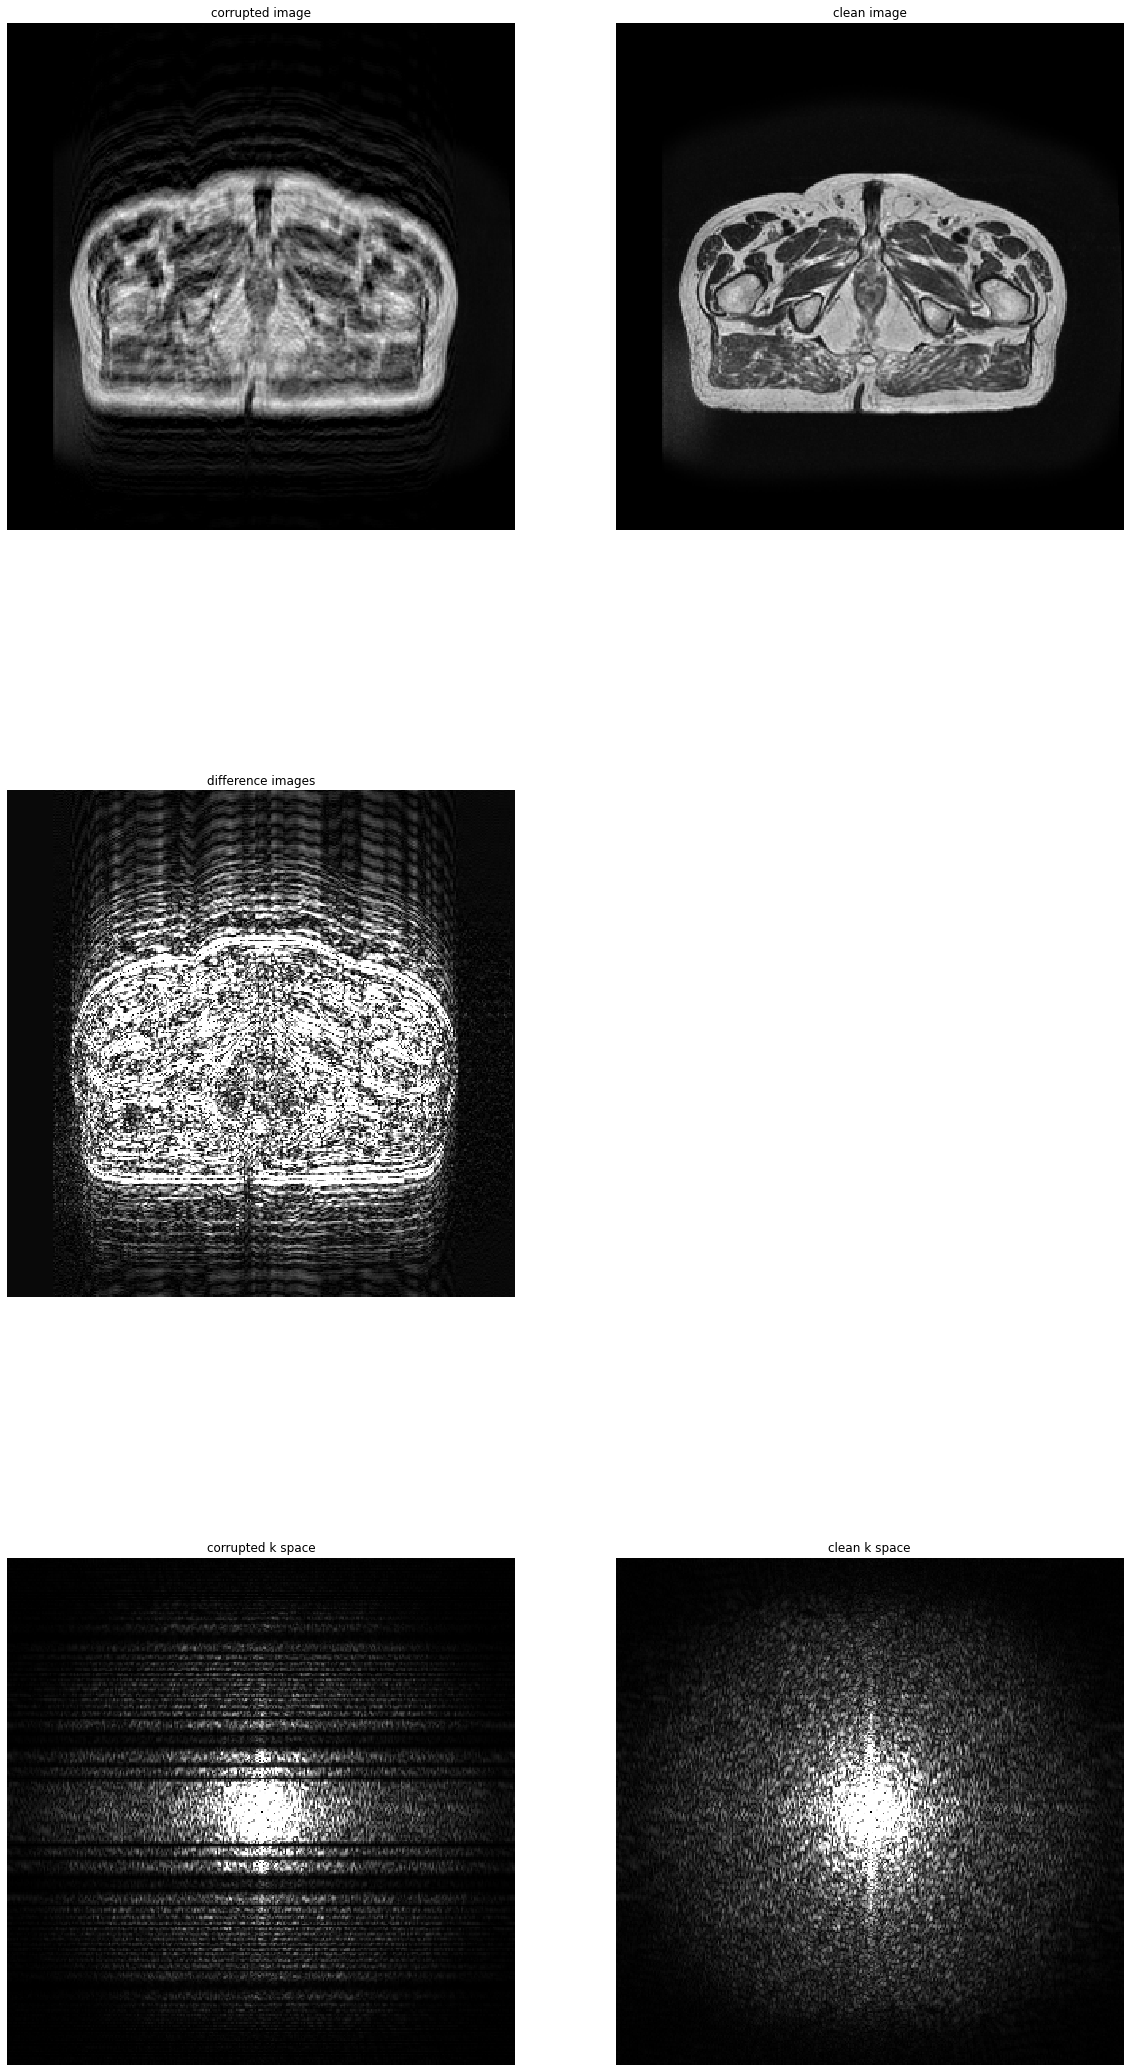

In [7]:
# plotting

img = corrupt(image, "motion")

hr = image
lr = img

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')

In [8]:
print(np.min(image), np.mean(image), np.std(image), np.max(image))
print(np.min(img), np.mean(img), np.std(img), np.max(img))

-0.6831006578710407 3.9968028886505634e-17 1.0 3.4597454358106914
-1.5891693721788756 2.2204460492503132e-17 1.0 3.6153522847405677


In [9]:
from sklearn.metrics import mean_squared_error
mean_squared_error(image, img)

0.128948495464721

In [10]:
# the artefacts should be well-balanced in terms of MSE

import os
from sklearn.metrics import mean_squared_error

images_path_list = []
main_path_brain = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM'
main_path_pelvis = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis2'
#main_path = r'C:\from SSD\fastMRI_brain_DICOM'
#main_path = r'D:\Pelvis_2.2'

folders_brain = os.listdir(main_path_brain)
folders_pelvis = os.listdir(main_path_pelvis)

for folder in folders_brain:
    folder_path = main_path_brain + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
for folder in folders_pelvis:
    folder_path = main_path_pelvis + '/' + folder
    images = os.listdir(folder_path)
    for image in images:
        image_path = folder_path + '/' + image
        images_path_list.append(image_path)
print(len(images_path_list))

488


In [11]:
#error_noise_image_total = []
#error_downsample_image_total = []
error_motion_image_total = []

#for number in batch:
#batch = np.random.randint(0, len(images_path_list), 1000)
#batch = np.arange(len(images_path_list))
#np.random.shuffle(batch)
#batch = batch[:10000]


#progress = np.linspace(0, len(images_path_list), 100, dtype=int)
#progress = np.linspace(0, len(batch), 100, dtype=int)
#i = 0
#j = 0

#import time 
#start = time.time()

for image_path in images_path_list:
#for number in batch: 
    #image_path = images_path_list[number]
    data = pydicom.dcmread(image_path)
    image = data.pixel_array   
    if (np.shape(image) != (320, 320)):
        image = cv2.resize(image, (320, 320))  
        
    #i += 1
    #if i in progress:
    #    j += 1
    #    print(j)
    
    if np.max(image) - np.min(image) > 1e-5:
        for i in range(10):
            image = (image - np.mean(image)) / np.std(image)

            #img_noise = corrupt(image, "noise")
            #img_downsample = corrupt(image, "downsample")
            img_motion = corrupt(image, "motion")

            #error_noise_image = mean_squared_error(image, img_noise)
            #error_downsample_image = mean_squared_error(image, img_downsample)
            error_motion_image = mean_squared_error(image, img_motion)

            #error_noise_image_total.append(error_noise_image)
            #error_downsample_image_total.append(error_downsample_image)
            error_motion_image_total.append(error_motion_image)

#finish = time.time()
#print('duration in minutes: {}'.format((finish-start)/60))

In [12]:
#print('average noise image error: {}'.format(sum(error_noise_image_total)/len(error_noise_image_total)))
#print('average downsample image error: {}'.format(sum(error_downsample_image_total)/len(error_downsample_image_total)))
print('average motion image error: {}'.format(sum(error_motion_image_total)/len(error_motion_image_total)))

average motion image error: 0.09954563892997038


In [14]:
print(np.mean(error_motion_image_total), np.std(error_motion_image_total))

0.09954563892997015 0.059220834768487315


In [ ]:
# 370490 brain images and 49125 pelvic images

# downsampling brain both PE direction
# duration in minutes: 111.75056455930074
# average downsample image error: 0.10005010006446843
# 0.10005010006446788 0.0883079130793548               0.11964699113260169 0.0888006130570558

# downsampling brain in LR direction
# duration in minutes: 114.6338830033938
# average downsample image error: 0.10419578276071505
# 0.10419578276071528 0.09015794175763622              

# downsampling pelvic both PE directions
# duration in minutes: 12.513582400480907
# average downsample image error: 0.10767694213748574
# 0.10767694213748634 0.04560943015074587              0.10604422588736447 0.04197583889572971

# noise brain [-10, 10]
# duration in minutes: 3.038319953282674
# average downsample image error: 0.09816729297950928
# 0.09816729297950953 0.0888686190628862

# noise pelvis [-10, 10]
# duration in minutes: 11.098158665498097
# average downsample image error: 0.10763057433589852
# 0.10763057433589744 0.045433794152409855